# Unsupervised learning example: Iris dimensionality

Let's take a look at reducing the dimensionality of the Iris data so as to more easily visualize it. Recall that the Iris data is four dimensional: there are four features recorded for each sample.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Load iris dataset
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
## Preprocess the data

# features
X_iris = iris.drop('species', axis=1)

# target
y_iris = iris['species']

# split into train & test
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_iris, y_iris,
                                                random_state=1)

The task of dimensionality reduction is to ask whether there is a suitable lower-dimensional representation that retains the essential features of the data. Often dimensionality reduction is used as an aid to visualizing data: after all, it is much easier to plot data in two dimensions that in four dimensions or higher!

Here we will use principal component analysis, which is a fast linear dimensionality reduction technique. We will ask the model to return two components—that is, a two-dimensional representation of the data.

Following the sequence of steps outlined earlier, we have:

In [4]:
# 1. Choose the model class
from sklearn.decomposition import PCA
# 2. Instantiate the model with hyperparameters
model = PCA(n_components=2)
# 3. Fit to data. Notice y is not specified!
model.fit(X_iris)
# 4. Transform the data to two dimensions
X_2D = model.transform(X_iris)

Now let's plot the result. A quick way to do this is to insert the result into the original Iris `DataFrame`, and use Seaborn `lmplot` to show the result.

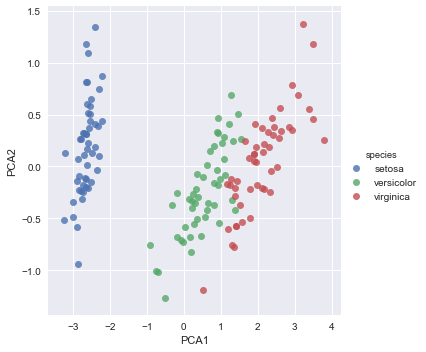

In [7]:
iris['PCA1'] = X_2D[:, 0]
iris['PCA2'] = X_2D[:, 1]
sns.lmplot("PCA1", "PCA2", hue='species', data=iris, fit_reg=False);

We see that in the two-dimensional representation, the species are fairly well seperated, even though the PCA algorithm has no knowledge of the species labels! This indicates to us that a relatively straightforward classification will probably be effective on the dataset, as we saw before.

## Unsupervised learning: Iris clustering

Let's next look at applying clustering to the iris data. A clustering algorithm attempts to find distinct group of data without reference to any labels. Here we will use a powerful clustering method called a Gaussian mixture model (GMM). A GMM attempts to model the data as a collection of Gaussian blobs.

In [17]:
# 1. Choose the model class
from sklearn.mixture import GMM
# 2. Instantiate the model with hyperparameters
model = GMM(n_components=3,
           covariance_type='full')
# 3. Fit to data. Notice y is not specified!
model.fit(X_iris)
# 4. Determine cluster labels
y_gmm = model.predict(X_iris)

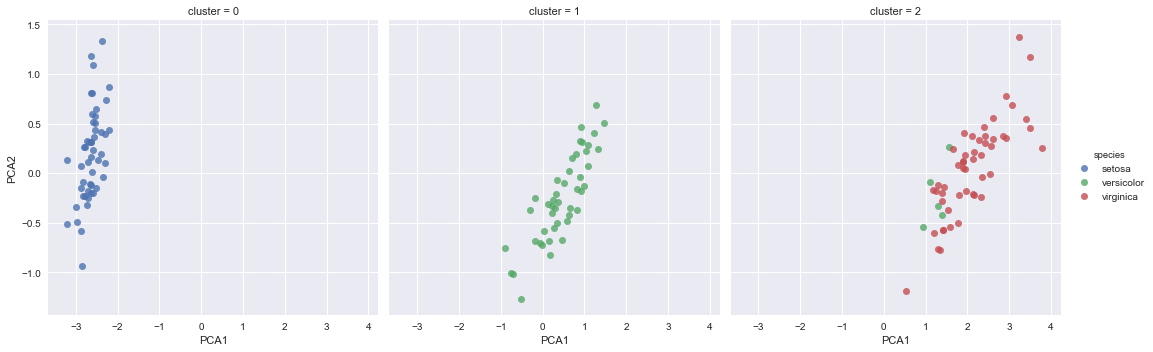

In [18]:
iris['cluster'] = y_gmm
sns.lmplot("PCA1", "PCA2", data=iris, hue='species',
           col='cluster', fit_reg=False);

By splitting the data by cluster number, we see exactly how well the GMM algorithm has recovered the underlying label: the setosa species is separated perfectly within cluster 0, while there remains a small amount of mixing between versicolor and virginica. This means that even without an expert to tell us the species labels of the individual flowers, the measurements of these flowers are distinct enough that we could automatically identify the presence of these different groups of species with a simple clustering algorithm! This sort of algorithm might further give experts in the field clues as to the relationship between the samples they are observing.

# Application: Exploring Hand written Digits

To demonstrate these principles on a more interesting problem, let's consider one piece of the optical character recognition problem: the identification of hand-written digits. In the wild, this problem involves both locating and identifying characters in an image. Here we'll take a shortcut and use Scikit-Learn's set of pre-formatted digits, which is built into the library.

## Loading and visualizing the digits data
We'll use Scikit-Learn's data access interface and take a look at this data:

In [31]:
from sklearn.datasets import load_digits
digits = load_digits()

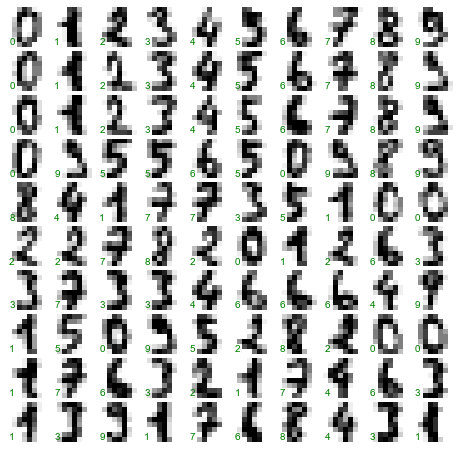

In [30]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
           transform=ax.transAxes, color='green')

In order to work with this data within Scikit-Learn, we need a two-dimensional, `[n_samples, n_features]` representation. We can accomplish this by treating each pixel in the images as a feature:that is, by flattening out the pixel arrays so that we have a length-64 array of pixel values representing each digit. Additionally, we need the target array, which gives the previously determined label for each digit. These two quantities are built into the digits dataset under the `data` and `target` attributes, respectively:

In [27]:
X = digits.data
X.shape

(1797, 64)

In [34]:
y = digits.target
y.shape

(1797,)

## Unsupervised learning: Dimensionality reduction

We'd like to visualize our points within the 64-dimensional parameter space, but it's difficult to effectively visualize points in such a high-dimensional space. Instead we'll reduce the dimensions to 2, using an unsupervised method. Here, we'll make use of a manifold learning algorithm called Isomap, and transform the data to two dimensions:


In [39]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

(1797, 2)

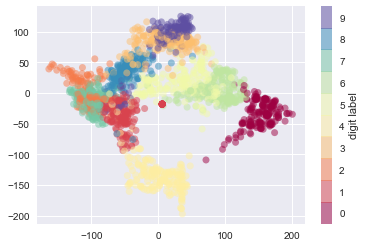

In [49]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,
           edgecolor='none', alpha=0.5,
           cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5)

## Classification on digits

Let's apply a classification algorithm to the digits. As with the Iris data previously, we will split the data into a training and testing set, and fit a Gaussian naive Bayes model:

In [50]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [51]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

In [52]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.8333333333333334

With even this extremely simple model, we find about 80% accuracy for classification of the digits! However, this single number doesn't tell us where we've gone wrong—one nice way to do this is to use the _confusion matrix_, which we can compute with Scikit-Learn and plot with Seaborn:

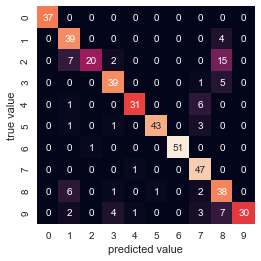

In [56]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_model)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

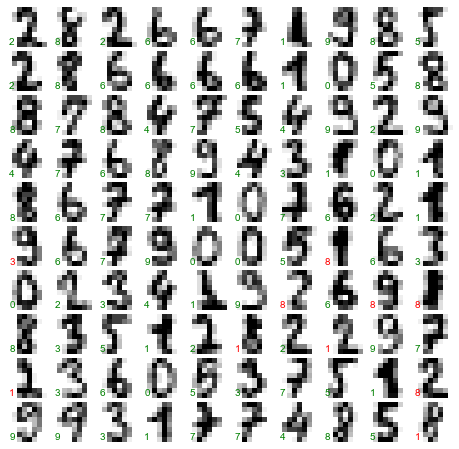

In [59]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 8, 8)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_model[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == y_model[i]) else 'red')